In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

import torch
from torch.utils.data import DataLoader
from torch import nn

from FaceNeuralNetwork import FaceNeuralNetwork, FaceDataset

data_folder_name = "data_p_B"
device = 'cpu' # 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'model_weights_p_B.pth'

meta_data = pd.read_csv(data_folder_name + "/meta_data.csv")

print("Loaded: Total samples={}, Training samples={}, Testing samples={}".format(len(meta_data), (meta_data['testing'] == 0).sum(), (meta_data['testing'] == 1).sum()))

Loaded: Total samples=1355, Training samples=1224, Testing samples=131


In [2]:
print('Using {} device'.format(device))
print('Loading model: {}'.format(model_name))

model = FaceNeuralNetwork().to(device)
checkpoint = torch.load(model_name)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

data_set = FaceDataset(
    data_folder_name + "/meta_data.csv", 
    data_folder_name + "/raw/",
    device
)
dataloader = DataLoader(data_set, batch_size=1, shuffle=False)

prec = 4
losses = []
x_preds = []
y_preds = []
loss_fn = nn.MSELoss()
with torch.no_grad():
    for i, (input_tensor, ground_truth) in enumerate(dataloader):
        pred = model(input_tensor)
        clamped_pred = torch.clamp(pred, min=0.0, max=1.0)
        losses.append(round(loss_fn(pred, ground_truth).item(), prec*2))
        x_preds.append(round(clamped_pred[0][0].item(), prec))
        y_preds.append(round(clamped_pred[0][1].item(), prec))
meta_data['loss'] = losses
meta_data['x_pred'] = x_preds
meta_data['y_pred'] = y_preds

Using cpu device
Loading model: model_weights_p_B.pth


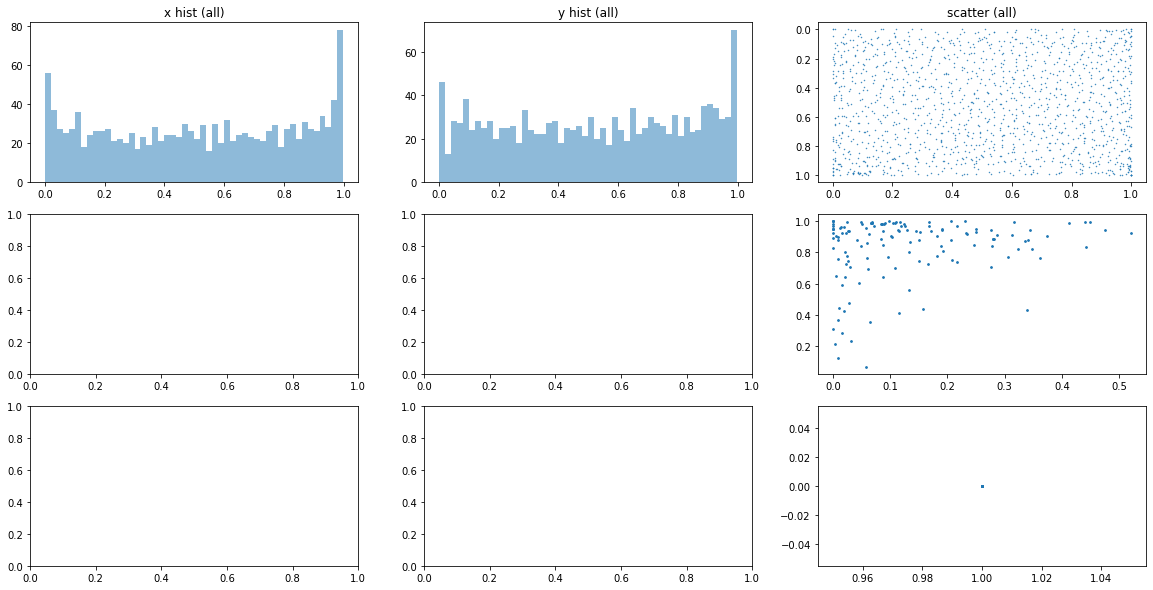

In [3]:
fig, axarr = plt.subplots(3, 3, figsize=(20,10))
axarr[0,0].set_title('x hist')
axarr[0,1].set_title('y_hist')
axarr[0,2].set_title('scatter')

bins = 50
alpha = 0.5
dot_size = 0.2

for (i, name, data) in [(0, 'all', meta_data)]: #, (1, 'training', training_data), (2, 'testing', testing_data)]:
    axarr[i,0].set_title('x hist ({})'.format(name))
    axarr[i,0].hist(data['x_screen'], bins=bins, alpha=alpha)
    # axarr[i,0].hist(data['x_pred'], bins=bins, alpha=alpha)

    axarr[i,1].set_title('y hist ({})'.format(name))
    axarr[i,1].hist(data['y_screen'], bins=bins, alpha=alpha)
    # axarr[i,1].hist(data['y_pred'], bins=bins, alpha=alpha)

    axarr[i,2].set_title('scatter ({})'.format(name))
    axarr[i,2].invert_yaxis()
    axarr[i,2].scatter(data['x_screen'], data['y_screen'], s=dot_size)
    # axarr[i,2].scatter(data['x_pred'], data['y_pred'], s=dot_size)
    
    most_error_instances = data[data['loss'] >= data['loss'].quantile(0.90)]
    axarr[i+1,2].scatter(most_error_instances['x_screen'] , most_error_instances['y_screen'], s=dot_size*15)
    axarr[i+2,2].scatter(most_error_instances['x_pred'] , most_error_instances['y_pred'], s=dot_size*15)

Worst loss: 3.74155211
best loss: 1.42674422


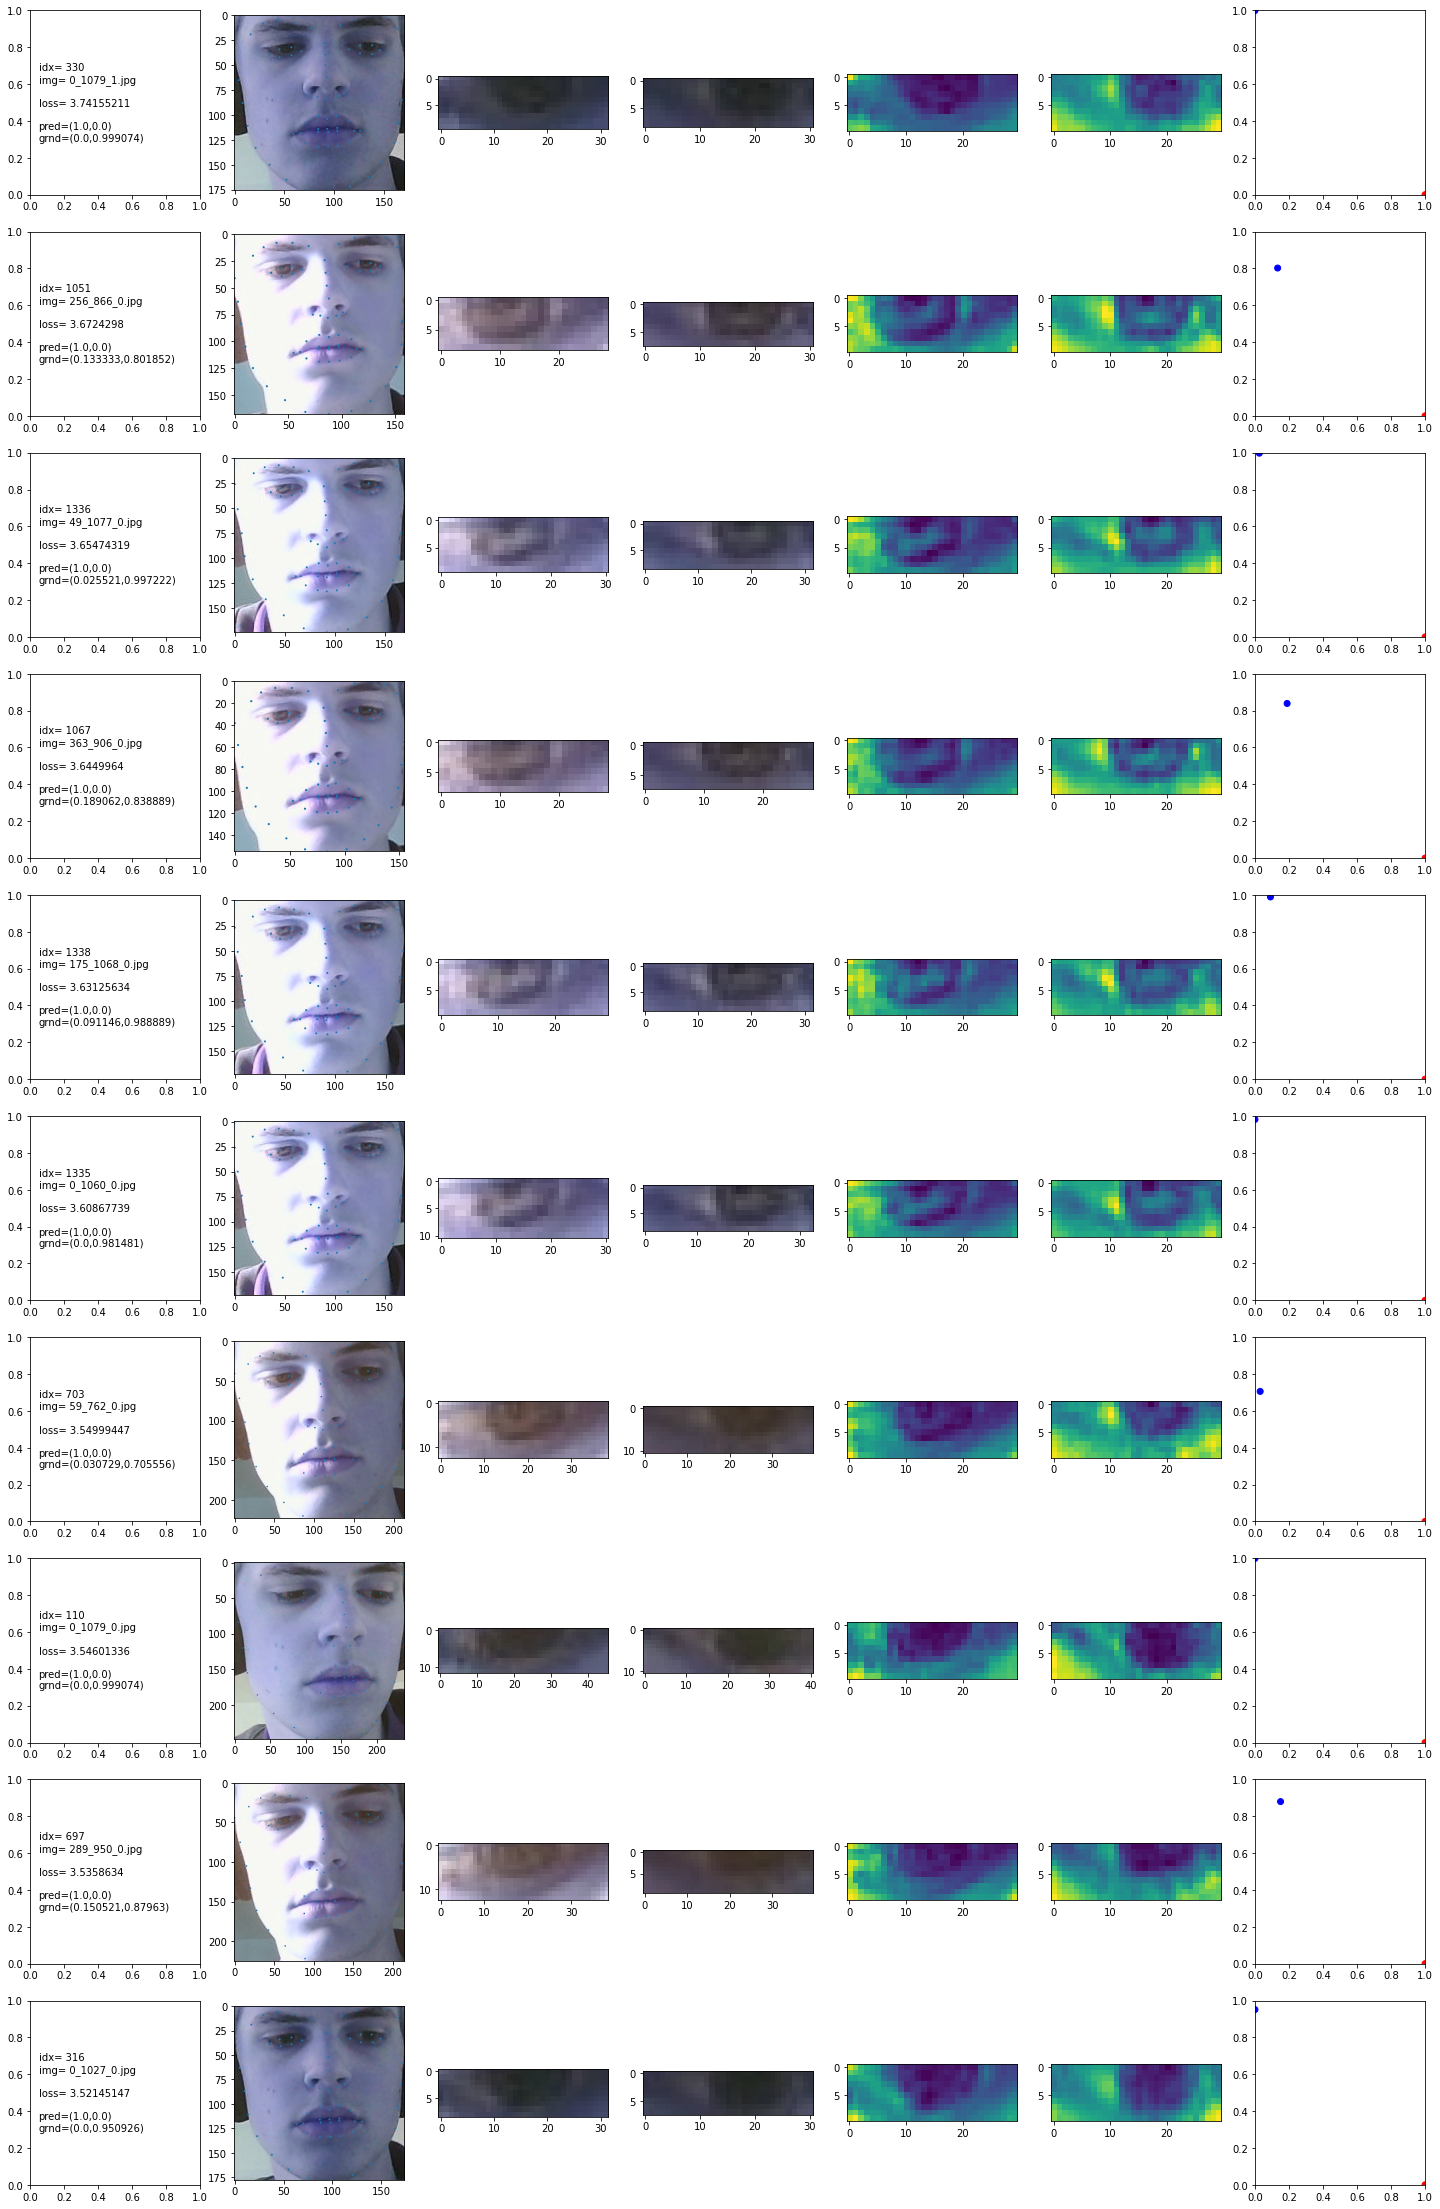

In [6]:
from matplotlib.patches import Circle

meta_data_loss_sorted = meta_data.sort_values(by='loss', ascending=False)

print("Worst loss: {}".format(meta_data_loss_sorted['loss'].iloc[0]))
print("best loss: {}".format(meta_data_loss_sorted['loss'].iloc[-1]))

item_count = 10
i = 0
f, axarr = plt.subplots(item_count, 7, figsize=(25,40))
for idx, row in meta_data_loss_sorted[:item_count].iterrows():
    face = data_set.get_face(row)
    text = "idx= {}\nimg= {}\n\nloss= {}\n\npred=({},{})\ngrnd=({},{})".format(idx, row['face_file_name'], row['loss'], row['x_pred'], row['y_pred'], row['x_screen'], row['y_screen'])
    axarr[i,0].text(0.05, 0.5, text, verticalalignment='center')

    left_eye_im, right_eye_im = face.get_eye_im(True), face.get_eye_im(False)
    axarr[i,1].imshow(face.im)
    for k in range(68):
        fx_k, fy_k = row['fx_' + str(k)], row['fy_' + str(k)]
        axarr[i,1].add_patch(Circle((fx_k*face.im.shape[1],fy_k*face.im.shape[0]),1))
    axarr[i,2].imshow(left_eye_im)
    axarr[i,3].imshow(right_eye_im)
    
    axarr[i,4].imshow(FaceDataset.pre_process_img(left_eye_im))
    axarr[i,5].imshow(FaceDataset.pre_process_img(right_eye_im))
    
    axarr[i,6].axis(xmin=0.0, xmax=1.0, ymin=0.0, ymax=1.0)
    axarr[i,6].scatter(x=[row['x_pred'], row['x_screen']], y=[row['y_pred'], row['y_screen']], color=['red', 'blue'])
    
    i += 1

In [5]:
____A = """
import cv2
from ipywidgets import interact

from EyeNeuralNetwork import EyeDataset

images = []
images_pre_proc = []
for index, row in all_data.iloc[300:305].iterrows():
    image = cv2.imread('data/raw/' + row[0])
    images.append(image)
    images_pre_proc.append(EyeDataset.pre_process_img(image))

@interact(kr=(1, 80), sig=(1, 20), c0=(0,300), c1=(0,300))
def g(kr, sig, c0, c1):
    imgs_pre2 = [cv2.normalize(img - cv2.GaussianBlur(img, (2*kr-1,2*kr-1), sig) + 127, None, 0, 255, cv2.NORM_MINMAX) for img in images]
    imgs_edge = [cv2.Canny(img, c0, c1) for img in imgs_pre2]
    f, axarr = plt.subplots(len(images), 4, figsize=(10,15))
    for i in range(len(images)):
        axarr[i,0].imshow(images[i])
        axarr[i,1].imshow(images_pre_proc[i])
        axarr[i,2].imshow(imgs_pre2[i])
        axarr[i,3].imshow(imgs_edge[i])
"""